(C) Gerold Baier, University College London, 2025

# Transition to Oscillations in Two Coupled Variables



## Mathematical Model

Single Variable, first-order differential equation

The equation:

$$ \frac{dEx}{dt} = h_{ex} - Ex + c_1*tanh(Ex) - c_2*tanh(In) $$
$$ \frac{dIn}{dt} = h_{in} - In + c_3*tanh(Ex) - c_4*tanh(In) $$

where $Ex$ and $In$ are variables that changes with time $t$, $h_{ex}$ and $c_i$ are model parameters, _tanh_ is the tangens hyperbolicus.

For $c_2 = c_3 = 0$, the two variables are uncoupled and independent. 

The model dynamics can be characterised by scans of parameter h_ex. Here, we use a slow continuous change of this parameter to simulate spontaneous qualitative transitions of dynamics in the human EEG. 


## Import Functions

In [7]:
from scipy.integrate import odeint
from scipy.signal import find_peaks, butter, sosfilt

from numpy import zeros, tanh, linspace, sqrt, fill_diagonal, ndarray
from numpy import asarray, array, around, arange, flip, var
from numpy.random import default_rng

from matplotlib.pyplot import subplots


## Model and Functions

In [9]:
def sigmoid(u):
    
    return tanh(u)

def single_oscillator(y, t, h_ex, h_in, pars):

    tau_ex, tau_in, c_1, c_2, c_3, c_4 = pars

    dydt = (
        (h_ex - y[0] + c_1*sigmoid(y[0]) - c_2*sigmoid(y[1]))*tau_ex,
        (h_in - y[1] + c_3*sigmoid(y[0]) - c_4*sigmoid(y[1]))*tau_in,
       )

    return dydt

def single_oscillator_plus_driving(y, t, h_ex, h_in, pars, sr, time_stop, driving, driving_strength):

    tau_ex, tau_in, c1, c2, c3, c4 = pars
    
    index = int(t*sr)
    
    if index >= time_stop*sr:
    
        dydt = zeros(2)
        
        return dydt
    
    h_ex_driven = h_ex + driving_strength*driving[index]

    dydt = (
        (h_ex_driven - y[0] + c1*sigmoid(y[0]) - c2*sigmoid(y[1]))*tau_ex,
        (h_in        - y[1] + c3*sigmoid(y[0]) - c4*sigmoid(y[1]))*tau_in,
   )

    return dydt

def single_oscillator_plus_driving_plus_noise(y, t, h_ex, h_in, pars, sr, time_stop, driving, driving_strength, random_data, random_strength):

    tau_ex, tau_in, c1_ex, c2_ex, c3_in, c4_in = pars
    
    index = int(t*sr)
    
    if index >= time_stop*sr:

        dydt = zeros(2)
        
        return dydt

    h_ex_driven = h_ex + driving_strength*driving[index]

    dydt = (
        (h_ex_driven - y[0] + c1_ex*sigmoid(y[0]) - c2_ex*sigmoid(y[1]) + 
         random_strength*random_data[index, 0])*tau_ex,
        (h_in        - y[1] + c3_in*sigmoid(y[0]) - c4_in*sigmoid(y[1]) + 
         random_strength*random_data[index, 1])*tau_in
   )

    return dydt

   

In [12]:
def plot_series(time, data, time_begin, time_end, sr):
    
    N = data.shape[1]//2
    
    name_vars = ('Ex', 'In')

    no_vars = 2*N

    fig, ax = subplots(ncols=2*N, figsize=(6, 4))

    for ind in arange(no_vars):

        ax[ind].plot(time[time_begin*sr:time_end*sr], data[time_begin*sr:time_end*sr, ind], linewidth=2, c='b')
        ax[ind].set_xticks(linspace(0, time_end-time_begin, 5));
        ax[ind].set_xticklabels(linspace(0, time_end-time_begin, 5));
        ax[ind].set_xlabel('Time', fontsize=12);
        ax[ind].set_ylabel(name_vars[ind], fontsize=12)
        y_min, y_max = ax[ind].get_ylim()
        ax[ind].set_yticks(linspace(y_min, y_max, 3));
        ax[ind].set_yticklabels(around(linspace(y_min, y_max, 3),1), fontsize=14);
    
    fig.tight_layout()
    
    return fig, ax


def plot_series_statespace(time, data, time_begin, time_end, sr):
    
    N = data.shape[1]//2
    
    name_vars = ('Ex', 'In')

    no_vars = 2*N

    fig, ax = subplots(ncols=2*N, figsize=(6, 4))

    ax[0].plot(time[time_begin*sr:time_end*sr], data[time_begin*sr:time_end*sr, 0], linewidth=2, c='b')
    ax[0].set_xticks(linspace(0, time_end-time_begin, 5));
    ax[0].set_xticklabels(linspace(0, time_end-time_begin, 5));
    ax[0].set_xlabel('Time', fontsize=12);
    y_min, y_max = ax[0].get_ylim()
    ax[0].set_yticks(linspace(y_min, y_max, 3));
    ax[0].set_yticklabels(around(linspace(y_min, y_max, 3),1), fontsize=14);
    ax[0].set_ylabel(name_vars[0], fontsize=12);

    ax[1].plot(data[time_begin*sr:time_end*sr, 1], data[time_begin*sr:time_end*sr, 0], linewidth=2, c='b')
    x_min, x_max = ax[1].get_xlim()
    ax[1].set_xticks(linspace(x_min, x_max, 3));
    ax[1].set_xticklabels(around(linspace(x_min, x_max, 3),1));
    ax[1].set_xlabel(name_vars[1], fontsize=12);
    ax[1].set_ylabel(name_vars[0], fontsize=12)
    y_min, y_max = ax[1].get_ylim()
    ax[1].set_yticks(linspace(y_min, y_max, 3));
    ax[1].set_yticklabels(around(linspace(y_min, y_max, 3),1), fontsize=14);
    ax[1].set_ylabel(name_vars[0], fontsize=12);

    fig.tight_layout()
    
    return fig, ax

In [14]:
def plot_bifdiagram(results_min_f, results_max_f, 
                    results_min_b, results_max_b,
                    par_set):
    
    N = len(results_min_f)

    fig, ax = subplots()

    for xe, ye in zip(par_set, results_max_f[0]):

        if not isinstance(ye, ndarray):
            ax.scatter(xe, ye, c='r', s=5)
        else:
            ax.scatter([xe] * len(ye), ye, c='m', s=50, marker='x')

    for xe, ye in zip(par_set, results_min_f[0]):

        if not isinstance(ye, ndarray):
            ax.scatter(xe, ye, c='r', s=5)
        else:
            ax.scatter([xe] * len(ye), ye, c='m', s=50, marker='x')

    for xe, ye in zip(flip(par_set), results_max_b[0]):

        if not isinstance(ye, ndarray):
            ax.scatter(xe, ye, c='r', s=5)
        else:
            ax.scatter([xe] * len(ye), ye, c='b', s=20, marker='P')

    for xe, ye in zip(flip(par_set), results_min_b[0]):

        if not isinstance(ye, ndarray):
            ax.scatter(xe, ye, c='r', s=5)
        else:
            ax.scatter([xe] * len(ye), ye, c='b', s=20, marker='P')

    ax.set_xticks(linspace(par_min, par_max, 5));
    ax.set_xticklabels(around(linspace(par_min, par_max, 5), 2), fontsize=16);
    ax.set_xlabel('Parameter', fontsize=16)

    ax.set_ylabel('Ex', fontsize=14)

    y_min, y_max = ax.get_ylim()

    ax.set_yticks(linspace(y_min, y_max, 3));
    ax.set_yticklabels(around(linspace(y_min, y_max, 3),2), fontsize=14);


    fig.tight_layout()
    
    return fig, ax


## Time Series


In [26]:
# Excitatory input parameter
h_ex_0    = -3.5
h_in_0    = -4

# Supercritical Hopf parameters
pars = (1, 1, 4, 6, 6, 0)
# Bistability parameters
# pars = (1, 1, 4, 1, 6, 0)

# Initial conditions
SEED = 123

rng = default_rng()

y_ini = rng.uniform(size=2)
# y_ini = y[-1, :]

# Time array
time_stop = 30
sr        = 1000
time      = linspace(start=0, stop=time_stop, num=time_stop*sr)

# Simulation
y = odeint(func=single_oscillator, y0=y_ini, t=time, 
          args=(h_ex_0, h_in_0, pars), 
          hmax=0.1)

# Show final values of all variables
print('End of run:', list(around(y[-1,:],3)))
print('')


End of run: [np.float64(0.501), np.float64(-2.864)]



Figs/SNIC_Timeseries_h_ex-3.5.png


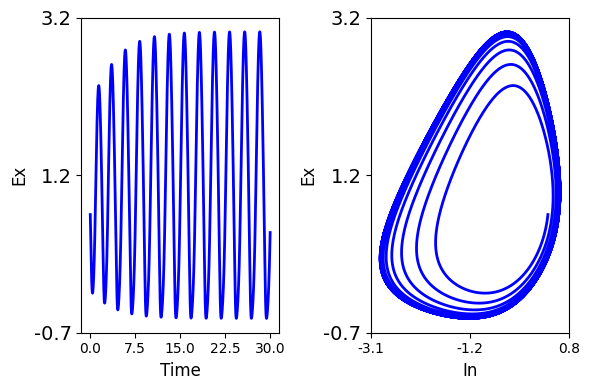

In [28]:
time_begin, time_end = 0, time_stop

fig, ax = plot_series_statespace(time, y, time_begin, time_end, sr)

title_chars = 'Figs/SNIC_Timeseries_h_ex' + str(h_ex_0) + '.png'
# fig.savefig(title_chars, format='png')
print(title_chars)


## Bifurcation Diagram

In [22]:
# Initial conditions
y_ini = y[-1, :]

# Bifurcation parameter range
steps = 50

par_min, par_max = -5, 2

par_set = linspace(par_min, par_max, steps)

# Stop time
time_stop = 500
time = linspace(start=0, stop=time_stop, num=time_stop*sr)


results_max_f      = dict()
results_max_inds_f = dict()
results_min_f      = dict()
results_min_inds_f = dict()

rows = time.size

# Simulation "forward"
for par in par_set:
    
    h_ex = par
    
    y_f = odeint(func=single_oscillator, y0=y_ini, t=time, 
             args=(h_ex, h_in_0, pars), 
             hmax=0.1)
 

    for num, series in enumerate(y_f[rows//2:,:-1:2].T):
                
        if var(series) < 0.00005:
            
            if num not in results_max_f:
                
                results_max_f[num]      = [series[-1]]
                results_max_inds_f[num] = [0]    
                results_min_f[num]      = [series[-1]]
                results_min_inds_f[num] = [0]    
                
            else:
                results_max_f[num].append(series[-1])
                results_max_inds_f[num].append(0)    
                results_min_f[num].append(series[-1])
                results_min_inds_f[num].append(0)               


        else:
            y_f_max_inds = find_peaks(series, distance=100)
            y_f_maxs     = series[y_f_max_inds[0]]

            y_f_min_inds = find_peaks(-series, distance=100)
            y_f_mins     = series[y_f_min_inds[0]]

            if num not in results_max_f:

                results_max_f[num]      = [y_f_maxs]
                results_max_inds_f[num] = [y_f_max_inds]
                results_min_f[num]      = [y_f_mins]    
                results_min_inds_f[num] = [y_f_min_inds]    

            else:

                results_max_f[num].append(y_f_maxs)
                results_max_inds_f[num].append(y_f_max_inds)
                results_min_f[num].append(y_f_mins)
                results_min_inds_f[num].append(y_f_min_inds)

    if par != par_set[-1]:
        
        y_ini = y_f[-1, :]


results_max_b      = dict()
results_max_inds_b = dict()
results_min_b      = dict()
results_min_inds_b = dict()

# Simulation "backward"
for par in flip(par_set):
    
    h_ex = par

    y_b = odeint(func=single_oscillator, y0=y_ini, t=time, 
             args=(h_ex, h_in_0, pars), 
             hmax=0.1)


    for num, series in enumerate(y_b[rows//2:,:-1:2].T):
        
        if var(series) < 0.00005:
            
            if num not in results_max_b:
                
                results_max_b[num]      = [series[-1]]
                results_max_inds_b[num] = [0]    
                results_min_b[num]      = [series[-1]]
                results_min_inds_b[num] = [0]    
                
            else:
                results_max_b[num].append(series[-1])
                results_max_inds_b[num].append(0)    
                results_min_b[num].append(series[-1])
                results_min_inds_b[num].append(0)               


        else:
            y_b_max_inds = find_peaks(series, distance=100)
            y_b_maxs     = series[y_b_max_inds[0]]

            y_b_min_inds = find_peaks(-series, distance=100)
            y_b_mins     = series[y_b_min_inds[0]]

            if num not in results_max_b:

                results_max_b[num]      = [y_b_maxs]
                results_max_inds_b[num] = [y_b_max_inds]
                results_min_b[num]      = [y_b_mins]    
                results_min_inds_b[num] = [y_b_min_inds]    

            else:

                results_max_b[num].append(y_b_maxs)
                results_max_inds_b[num].append(y_b_max_inds)
                results_min_b[num].append(y_b_mins)
                results_min_inds_b[num].append(y_b_min_inds)

    y_ini = y_b[-1, :]

print('')
print('Scan complete!')
print('')



Scan complete!



'1osc_Bifs_h_ex, c_2=6.png'

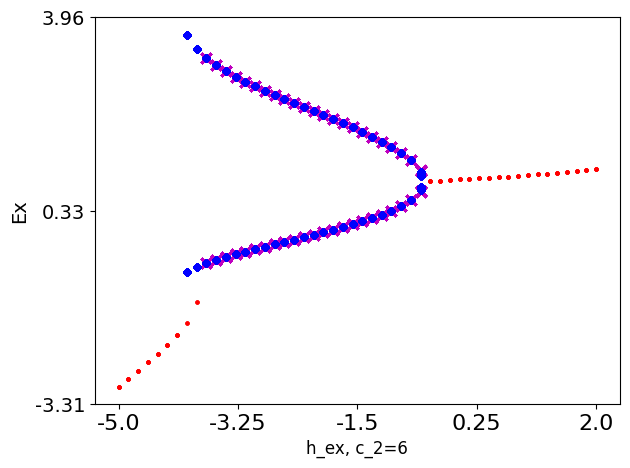

In [23]:
# Plot
fig, ax = plot_bifdiagram(results_min_f, results_max_f, 
                          results_min_b, results_max_b, par_set)


ax.set_xlabel('h_ex, c_2=' + str(pars[3]), fontsize=12)

title_chars = '1osc_Bifs' + '_h_ex, c_2=' + str(pars[3]) + '.png'
# fig.savefig(title_chars, format='png')
title_chars


## Transition to oscillation


In [30]:
# Set Initial conditions:
y_ini = y[-1, :]

# Time array
time_stop = 500
time      = linspace(start=0, stop=time_stop, num=time_stop*sr)

# Initial parameter value
h_ex_0    = -4.5

# Driving
driving = linspace(0, 1, time.size)
driving_strength = 1

y = odeint(func=single_oscillator_plus_driving, y0=y_ini, t=time, 
              args=(h_ex_0, h_in_0, pars, sr, time_stop, driving, driving_strength), hmax=0.1)


print('End of run:', y.shape)
print('')


End of run: (500000, 2)



Figs/N=1/Onset_SNIC_h_ex.png


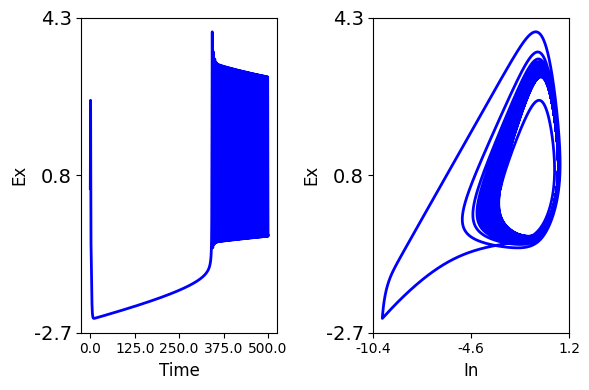

In [32]:
time_begin, time_end = 0, time_stop

fig, ax = plot_series_statespace(time, y, time_begin, time_end, sr)

if pars[1] == 1:
    
    title_chars = 'Figs/N=1/Onset_SNIC_h_ex.png'
    
elif pars[1] == 2:

    title_chars = 'Figs/N=1/Onset_Homoclinic_h_ex.png'
  
# fig.savefig(title_chars, dpi=300, format='png', bbox_inches='tight')

print(title_chars)

## With added noise

In [34]:
# Set Initial conditions:
# y_ini = y[-1, :]

# Time array
time_stop = 50
time      = linspace(start=0, stop=time_stop, num=time_stop*sr)

# Initial parameter value
h_ex_0    = -4.2

# Driving
driving = linspace(0, 1, time.size)
driving_strength = 1.0

# Noise
SEED = 123

rng = default_rng(SEED)

random_data = rng.normal(size=(time.size, y.shape[1]))

order, band_low, band_high = 5, 1, 10

sos = butter(order, (band_low, band_high), btype='bandpass', fs=sr, output='sos')

random_data_filtered = zeros((time.size, y.shape[1]))

for index, column in enumerate(random_data.transpose()): 
    forward   = sosfilt(sos, column)
    backwards = sosfilt(sos, forward[-1::-1])
    random_data_filtered[:, index] = backwards[-1::-1]

random_strength = 10

# Simulation /Add noise arrays to params
y = odeint(func=single_oscillator_plus_driving_plus_noise, y0=y_ini, t=time, 
          args=(h_ex_0, h_in_0, pars, sr, time_stop, driving, driving_strength, 
           random_data_filtered, random_strength), hmax=0.1)

print('End of run:')
print('')


End of run:



Figs/N=1/Onset_SNIC_h_ex.png


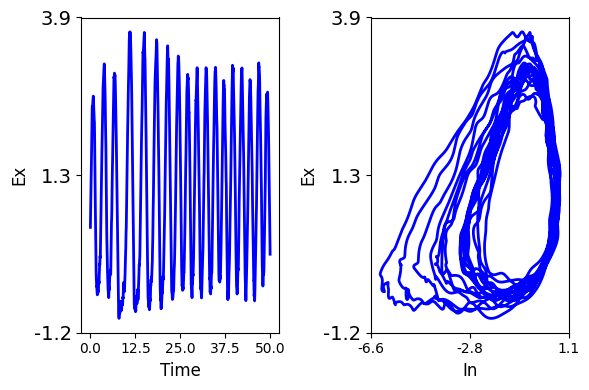

In [36]:
time_begin, time_end = 0, time_stop

fig, ax = plot_series_statespace(time, y, time_begin, time_end, sr)

if pars[1] == 1:
    
    title_chars = 'Figs/N=1/Onset_SNIC_h_ex.png'
    
elif pars[1] == 2:

    title_chars = 'Figs/N=1/Onset_Homoclinic_h_ex.png'
  
# fig.savefig(title_chars, dpi=300, format='png', bbox_inches='tight')

print(title_chars)

# Try it Yourself

Re-run the above code with these parameter settings:

pars             $= (1.2, 0.1, 4, 6, 6, 0)$

h_ex_0           $= 0.2$

driving_strength $=-2$

to simulate an onset with small fast oscillations that grow in amplitude. This is another common type of seizure onset in humans. 



# Notes on the Reading

## A taxonomy of seizure dynamotypes, Maria Luisa Saggio et al

In this paper, transitions to epileptic seizures as recorded in invasive EEG are classified according to a small number of bifurcations in two-variable dynamical systems. 
Seizure onset is considered as a transition from fixed point to oscillations and there are four types of such transitions as a function of changes in a single parameter. Saddle-node in invariant cycle (SNIC) lead to sudden onset of large amplitude slow frequency oscillations. Supercritical Hopf bifurcations results in small amplitude fast oscillations with increasing amplitude. Figure 1 is a schematic of all possible types of this low-dimensional approach. Appendix 1, page 29, gives clinical examples of seizure onsets and their interpretation according to dynmical systems theory. 
